In [10]:
!rm conference.zip
!rm reference-alignment.zip
!wget http: // oaei.ontologymatching.org / 2021 / conference / data / conference.zip
!wget http: // oaei.ontologymatching.org / 2021 / conference / data / reference-alignment.zip

!unzip -qo conference.zip -d conference
!unzip -qo reference-alignment.zip -d reference


!pip install git+https: // github.com / guihcs / omatch
!pip install termcolor

--2022-04-24 11:59:05--  http://oaei.ontologymatching.org/2021/conference/data/conference.zip
Resolving oaei.ontologymatching.org (oaei.ontologymatching.org)... 194.199.16.67
Connecting to oaei.ontologymatching.org (oaei.ontologymatching.org)|194.199.16.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55387 (54K) [application/zip]
Saving to: ‘conference.zip’

conference.zip      100%[===================>]  54.09K   274KB/s    in 0.2s    

2022-04-24 11:59:06 (274 KB/s) - ‘conference.zip’ saved [55387/55387]

--2022-04-24 11:59:06--  http://oaei.ontologymatching.org/2021/conference/data/reference-alignment.zip
Resolving oaei.ontologymatching.org (oaei.ontologymatching.org)... 194.199.16.67
Connecting to oaei.ontologymatching.org (oaei.ontologymatching.org)|194.199.16.67|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16852 (16K) [application/zip]
Saving to: ‘reference-alignment.zip’

reference-alignment 100%[===================>]  16.4

In [ ]:
!wget https: // huggingface.co / stanfordnlp / glove / resolve / main / glove.42B.300d.zip
!unzip -qo glove.42B.300d.zip

--2022-04-23 09:56:58--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip
Resolving huggingface.co (huggingface.co)... 34.197.58.156, 34.200.173.213, 34.224.55.150, ...
Connecting to huggingface.co (huggingface.co)|34.197.58.156|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a [following]
--2022-04-23 09:56:58--  https://cdn-lfs.huggingface.co/stanfordnlp/glove/357baac33090f645e71e253b3295ee1b767c98a0336e9a1d99c77e9e33b43c4a
Resolving cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)... 54.230.104.26, 54.230.104.5, 54.230.104.57, ...
Connecting to cdn-lfs.huggingface.co (cdn-lfs.huggingface.co)|54.230.104.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877802108 (1,7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

100%[====================================>] 1.877.802.108 50,9MB/s   in 46s

In [ ]:
!rm ontology.ttl
!wget https: // raw.githubusercontent.com / dbpedia / ontology-tracker / master / ontology / ontology.ttl

--2022-04-23 10:37:37--  https://raw.githubusercontent.com/dbpedia/ontology-tracker/master/ontology/ontology.ttl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310926 (1,2M) [text/plain]
Saving to: ‘ontology.ttl’

100%[======================================>] 1.310.926   --.-K/s   in 0,09s   

2022-04-23 10:37:37 (13,9 MB/s) - ‘ontology.ttl’ saved [1310926/1310926]



In [ ]:
!pip install torch torchvision torchaudio
!pip install matplotlib

     |████████████████████████████████| 881.9 MB 23 kB/s              
     |████████████████████████████████| 23.3 MB 18.4 MB/s            
     |████████████████████████████████| 2.9 MB 24.4 MB/s            
     |████████████████████████████████| 3.1 MB 23.4 MB/s            
     |████████████████████████████████| 881.9 MB 25 kB/s              


In [11]:
!pip install -U pymagnitude

In [1]:
from om.match import onts, aligns
from om.ont import split_entity, pt, remove_bn
from om.util import Cross
from termcolor import colored
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from om.match import Runner, print_result, Step
from om.util import Cross, get_vocab, WordMap
import math
import random
import pandas as pd
from om.ont import get_n, noisy_copy, remove_bn
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import RDF, RDFS, OWL
import os
from pymagnitude import *

/moredata/gsantos/miniconda3/lib/python3.9/site-packages/om/ont.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def eval_result(result, rang):
    if len(result) <= 1:
        result[0].drop('name', axis=1).mean().plot.bar(rot=0)
        f = [0]
    else:
        p = []
        r = []
        f = []

        for q in result:
            v = q.drop('name', axis=1).mean()

            p.append(v['precision'])
            r.append(v['recall'])
            f.append(v['f1'])

        plt.figure(figsize=(10, 5))
        plt.plot(rang, p, c='r')
        plt.plot(rang, r, c='g')
        plt.plot(rang, f, c='b')
        plt.show()

    print(rang[np.argmax(f)])
    print_result(result[np.argmax(f)])

    rd = dict()

    for n in result[0]['name'].unique():
        l = result[0][result[0]['name'] == n].copy()
        l['th'] = 0
        rd[n] = l

    for i in range(len(rang)):
        for n in result[i]['name'].unique():
            l = result[i][result[i]['name'] == n].copy()
            l['th'] = rang[i]

            if l['f1'].iloc[0] > rd[n]['f1'].iloc[0]:
                rd[n] = l

    print('\n\noracle th ---------------------')
    print_result(pd.concat(rd.values()))





In [3]:
def build_adj(g):
    ents = list(get_vocab(g))

    random.shuffle(ents)
    l = len(ents)
    adj = torch.zeros((l, l))
    pdj = -torch.ones((l, l))

    wm = WordMap(ents)

    for s, p, o in g:

        adj[wm[s]][wm[o]] = 1
        pdj[wm[s]][wm[o]] = wm[p]

        if (s, RDFS.domain, None) in g and (s, RDFS.range, None) in g:
            domain = g.value(s, RDFS.domain)
            rg = g.value(s, RDFS.range)

            adj[wm[domain]][wm[rg]] = 1
            pdj[wm[s]][wm[o]] = wm[s]

            adj[wm[rg]][wm[domain]] = -1
            pdj[wm[rg]][wm[domain]] = wm[s]

        if (s, RDFS.subClassOf, None) in g:
            for ob in g.objects(s, RDFS.subClassOf):
                adj[wm[s]][wm[ob]] = 1
                pdj[wm[s]][wm[ob]] = wm[RDFS.subClassOf]

                adj[wm[ob]][wm[s]] = -1
                pdj[wm[ob]][wm[s]] = wm[RDFS.subClassOf]

    return ents, adj, pdj.long()

In [4]:
class MDataset(Dataset):

    def __init__(self, dtsn, als, g1, g2, tb=1, fb=1, cache=False, cacheLen=500000):
        self.transform = None
        self.cache = cache
        self.cacheLen = cacheLen
        self.dtsn = dtsn + '-cache.bin'
        if os.path.exists(self.dtsn):
            os.remove(self.dtsn)

        self.g1 = g1
        self.g2 = g2
        self.als = als

        with torch.no_grad():
            self.ents1, self.adj1, self.pdj1 = build_adj(self.g1)
            self.ents2, self.adj2, self.pdj2 = build_adj(self.g2)

        tc = 0
        nc = 0
        self.data = []
        self.dl = 0
        self.li = -1 if self.cache else 0
        self.mi = -1

        for e1 in tqdm(set(self.g1.subjects())):
            for e2 in set(self.g2.subjects()):
                if random.random() < (1 - fb):
                    continue
                sim = torch.Tensor([1 if (e1, e2) in self.als else -1])

                for _ in range(1 if sim != 1 else tb):
                    if sim != 1:
                        nc += 1
                    else:
                        tc += 1
                    self.dl += 1

                    self.data.append((e1, e2, sim))

                    if self.cache and len(self.data) >= self.cacheLen:
                        random.shuffle(self.data)
                        self._cache()
                        self.data = []

        if self.cache:
            random.shuffle(self.data)
            self._cache()
            self.data = []

        print(f'{len(self)} instances. {tc} true, {nc} false.')

    def _cache(self):
        lines = []
        for e1, e2, s in self.data:
            lines.append(str(e1).encode('utf-8').ljust(500) + str(e2).encode('utf-8').ljust(500) + str(s.item()).encode(
                'utf-8').ljust(50))

        with open(self.dtsn, 'ab') as f:
            f.writelines(lines)

    def _loadblock(self, i, ml):
        self.data = []
        ls = 500 + 500 + 50

        with open(self.dtsn, 'rb') as f:
            f.seek(i * ls)
            rd = f.read(ml * ls)

        for fi in range(ml):
            line = rd[fi * ls:(fi + 1) * ls]
            u1 = line[:500].decode('utf-8').strip()
            u2 = line[500:1000].decode('utf-8').strip()
            s = line[1000:1050].decode('utf-8').strip()

            self.data.append((URIRef(u1), URIRef(u2), torch.Tensor([float(s)])))

        self.li = i
        self.mi = i + ml

    def __getitem__(self, i):
        if self.cache and (i >= self.mi or i < self.li):
            self._loadblock(i, min(self.dl - i, 200000))

        return self.data[i - self.li]

    def __len__(self):
        return self.dl


class MatchDataset(MDataset):

    def __init__(self, r, o1, o2, tb=1):
        g1 = Graph()
        g1.parse(o1)
        g2 = Graph()
        g2.parse(o2)

        als = set(map(lambda x: (URIRef(x[0]), URIRef(x[1])), aligns(r)))

        super().__init__('none', als, g1, g2, tb=tb)



In [5]:
class EqMatcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        ents = self.cross(dataset)
        res = []
        for e1, e2 in ents:
            n1 = get_n(e1, dataset.g1)
            n2 = get_n(e2, dataset.g2)

            res.append((e1, e2, 1 if n1 == n2 else 0))

        return [res], {}



In [17]:
!wget http: // magnitude.plasticity.ai / glove / medium / glove.840B.300d.magnitude

--2022-04-24 12:00:22--  http://magnitude.plasticity.ai/glove/medium/glove.840B.300d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.217.229.197
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.217.229.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3646562304 (3.4G) [binary/octet-stream]
Saving to: ‘glove.840B.300d.magnitude’

glove.840B.300d.mag 100%[===================>]   3.40G  60.4MB/s    in 62s     

2022-04-24 12:01:24 (56.5 MB/s) - ‘glove.840B.300d.magnitude’ saved [3646562304/3646562304]



In [6]:
glove = Magnitude('/moredata/gsantos/canard/glove.840B.300d.magnitude')

In [7]:
g1 = Graph()
g1.parse('/moredata/gsantos/canard/conference/cmt.owl')

remove_bn(g1)

g2 = Graph()
g2.parse('/moredata/gsantos/canard/conference/confOf.owl')

remove_bn(g2)

g3 = Graph()
g3.parse('/moredata/gsantos/canard/conference/Conference.owl')

remove_bn(g3)

g4 = Graph()
g4.parse('/moredata/gsantos/canard/conference/edas.owl')

remove_bn(g4)

g5 = Graph()
g5.parse('/moredata/gsantos/canard/conference/ekaw.owl')

remove_bn(g5)

g6 = Graph()
g6.parse('/moredata/gsantos/canard/conference/iasted.owl')

remove_bn(g6)

g7 = Graph()
g7.parse('/moredata/gsantos/canard/conference/sigkdd.owl')

remove_bn(g7)

In [8]:

als1 = set(map(lambda x: (x, x), set(g1.subjects())))
als2 = set(map(lambda x: (x, x), set(g2.subjects())))
als3 = set(map(lambda x: (x, x), set(g3.subjects())))
als4 = set(map(lambda x: (x, x), set(g4.subjects())))
als5 = set(map(lambda x: (x, x), set(g5.subjects())))
als6 = set(map(lambda x: (x, x), set(g6.subjects())))
als7 = set(map(lambda x: (x, x), set(g7.subjects())))

datasets = [
    MDataset('dts1', als1, g1, g1, tb=90, fb=1, cache=False),
    MDataset('dts1', als2, g2, g2, tb=90, fb=1, cache=False),
    MDataset('dts1', als3, g3, g3, tb=150, fb=1, cache=False),
    MDataset('dts1', als4, g4, g4, tb=280, fb=1, cache=False),
    MDataset('dts1', als5, g5, g5, tb=150, fb=1, cache=False),
    MDataset('dts1', als6, g6, g6, tb=250, fb=1, cache=False),
    MDataset('dts1', als7, g7, g7, tb=150, fb=1, cache=False)
]

  0%|          | 0/99 [00:00<?, ?it/s]

18612 instances. 8910 true, 9702 false.


  0%|          | 0/99 [00:00<?, ?it/s]

18612 instances. 8910 true, 9702 false.


  0%|          | 0/155 [00:00<?, ?it/s]

47120 instances. 23250 true, 23870 false.


  0%|          | 0/297 [00:00<?, ?it/s]

171072 instances. 83160 true, 87912 false.


  0%|          | 0/124 [00:00<?, ?it/s]

33852 instances. 18600 true, 15252 false.


  0%|          | 0/247 [00:00<?, ?it/s]

122512 instances. 61750 true, 60762 false.


  0%|          | 0/89 [00:00<?, ?it/s]

21182 instances. 13350 true, 7832 false.


In [9]:
def emb_ents(ents, g):
    embs = []

    for i in range(len(ents)):
        e = ents[i]

        if type(e) is BNode:
            emb = torch.zeros((1, 300))

        elif type(e) is Literal:
            words = split_entity(e)
            emb = sum(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), words)) / len(words)
        else:

            n = e.n3(g.namespace_manager)
            if n.startswith('<'):
                n = n.split('/')[-1]
            else:
                n = n.split(':')[-1]

            words = split_entity(n)
            if len(words) <= 0:
                emb = torch.zeros((1, 300))
            else:
                emb = sum(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), words)) / len(words)
        embs.append(emb)
    return torch.cat(embs)


In [11]:
class GNAH(nn.Module):

    def __init__(self, emblen):
        super().__init__()
        self.emblen = emblen
        self.w = nn.Linear(emblen, emblen, bias=False)
        self.a = nn.Linear(emblen * 2, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2)
        self.pc = nn.Linear(emblen * 2, emblen)

    def forward(self, embs, adj, pde):
        adc = torch.clone(adj)

        wf = self.w(embs)
        rm = wf.view(wf.shape[0], 1, wf.shape[1]).repeat(1, wf.shape[0], 1)
        cm = wf.view(1, wf.shape[0], wf.shape[1]).repeat(wf.shape[0], 1, 1)

        pc = torch.cat([cm, pde], dim=2)
        pc = self.lrelu(self.pc(pc))
        pc = self.w(pc)

        mf = self.lrelu(self.a(torch.cat([rm, pc], dim=2)))
        mf = mf.view(mf.shape[0], mf.shape[1])
        me = torch.nan_to_num((adc - 1) * float('inf')).to(torch.device('cuda:0'))
        mf = torch.softmax(mf + me, dim=1)

        nbc = mf @ embs

        res = torch.cat([embs, nbc], dim=1)

        return res


class MHAG(nn.Module):

    def __init__(self, emblen, heads):
        super().__init__()
        self.emblen = emblen
        self.heads = heads
        self.heads = nn.ModuleList([GNAH(emblen) for _ in range(heads)])
        self.ch = nn.Linear(emblen * heads * 2, emblen)

    def forward(self, embs, adj, pdj):
        pe = torch.cat([embs, torch.zeros((1, self.emblen)).to(torch.device('cuda:0'))])
        pde = pe[pdj]

        res = [h(embs, adj, pde) for h in self.heads]

        rm = self.ch(torch.cat(res, dim=1))

        return rm


class GNN(nn.Module):

    def __init__(self, emblen, heads, nodes):
        super().__init__()
        self.emblen = emblen
        self.heads = heads
        self.nodes = nodes
        self.an = nn.ModuleList([MHAG(emblen, heads) for _ in range(nodes)])

    def forward(self, embs, adj, pdj):
        res = embs

        for n in self.an:
            res = n(res, adj, pdj)

        return res

In [12]:
device = torch.device('cuda:0')

emblen = 300
epochs = 3
lr = 0.0003

crit = nn.CosineEmbeddingLoss(margin=0.4)

gnn = GNN(emblen, 2, 1)
gnn.to(device)
optimizer = optim.Adam(gnn.parameters(), lr=lr)
lh = []



In [ ]:

q = tqdm(total=0.5)
for epcq in tqdm(range(epochs)):
    el = 0
    for data in datasets:

        dl = 0
        bs = 256

        embs1 = emb_ents(data.ents1, data.g1)
        embs2 = emb_ents(data.ents2, data.g2)

        wm1 = WordMap(data.ents1)
        wm2 = WordMap(data.ents2)

        for e1, e2, s in tqdm(DataLoader(data, batch_size=bs), leave=False):
            optimizer.zero_grad()

            m1 = gnn(embs1.to(device), data.adj1.to(device), data.pdj1.to(device))
            m2 = gnn(embs2.to(device), data.adj2.to(device), data.pdj2.to(device))

            r1 = list(map(lambda x: m1[wm1[x]].unsqueeze(0), e1))
            r2 = list(map(lambda x: m2[wm2[x]].unsqueeze(0), e2))

            r1 = torch.cat(r1).to(torch.device('cpu'))
            r2 = torch.cat(r2).to(torch.device('cpu'))

            loss = crit(r1, r2, s.flatten())
            loss.backward()

            optimizer.step()
            dl += loss.item()

            # break

        dl /= (len(data) / bs)
        el += dl


        # break

    el /= len(datasets)
    lh.append(el)
    torch.save(gnn.state_dict(), f'gnn-conf-{epcq}.pt')
    # break

plt.plot(lh)
plt.show()


  0%|          | 0/0.5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/669 [00:00<?, ?it/s]

In [ ]:
torch.save(gnn.state_dict(), 'gnn.pt')

In [31]:
gnn = GNN(emblen, 2, 1)
gnn.load_state_dict(torch.load('gnn-conf-2.pt'))

<All keys matched successfully>

In [14]:
rang = np.arange(0.1, 1, 0.01)

gnn.to(torch.device('cuda:0'))
class Matcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        ents = self.cross(dataset)

        ents1, adj1, pdj1 = build_adj(dataset.g1)
        ents2, adj2, pdj2 = build_adj(dataset.g2)
        embs1 = emb_ents(ents1, dataset.g1)
        embs2 = emb_ents(ents2, dataset.g2)

        wi1 = WordMap(ents1)
        wi2 = WordMap(ents2)


        with torch.no_grad():
            m1 = gnn(embs1.to(torch.device('cuda:0')), adj1.to(torch.device('cuda:0')), pdj1.to(torch.device('cuda:0'))).to(torch.device('cpu'))
            m2 = gnn(embs2.to(torch.device('cuda:0')), adj2.to(torch.device('cuda:0')), pdj2.to(torch.device('cuda:0'))).to(torch.device('cpu'))





        res = [[] for r in rang]
        for e1, e2 in ents:

            r1 = m1[wi1[e1]].unsqueeze(0)
            r2 = m2[wi2[e2]].unsqueeze(0)

            s = F.cosine_similarity(r1, r2)
            s = s.item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}


class GloveMatcher(Step):

    def __init__(self):
        self.cross = Cross()

    def forward(self, dataset, i):
        g1 = dataset.g1
        g2 = dataset.g2

        remove_bn(g1)
        remove_bn(g2)

        ents1 = set(g1.subjects())
        ents2 = set(g2.subjects())

        m1 = dict()

        for e1 in ents1:
            n1 = e1.n3(g1.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m1[e1] = sv.squeeze(0)

        m2 = dict()

        for e1 in ents2:
            n1 = e1.n3(g2.namespace_manager)
            n1 = map(lambda x: x.lower(), split_entity(n1))
            n1 = list(map(lambda x: torch.Tensor([list(glove.query(x.lower()))]), n1))
            ln = len(n1)
            sv = sum(n1) / ln

            m2[e1] = sv.squeeze(0)

        ents = self.cross(dataset)

        res = [[] for r in rang]
        for e1, e2 in ents:

            r1 = m1[e1]
            r2 = m2[e2]

            s = F.cosine_similarity(r1.unsqueeze(0), r2.unsqueeze(0)).item()
            for i in range(len(rang)):
                sim = 1 if s > rang[i] else 0
                res[i].append((e1, e2, sim))

        return res, {}


kgome


  0%|          | 0/21 [00:00<?, ?it/s]

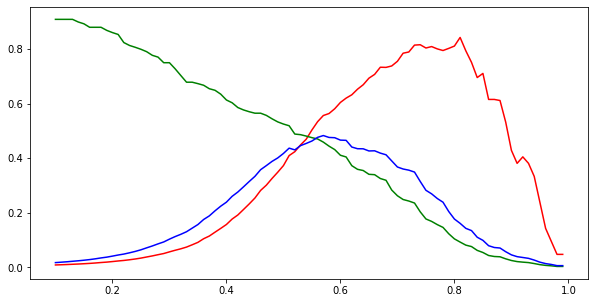

0.5699999999999997
                     name  precision    recall        f1
0   conference-iasted.rdf   0.500000  0.166667  0.250000
1         edas-sigkdd.rdf   0.666667  0.363636  0.470588
2         edas-iasted.rdf   0.470588  0.266667  0.340426
3           edas-ekaw.rdf   0.379310  0.314286  0.343750
4         confOf-edas.rdf   0.400000  0.461538  0.428571
5     conference-ekaw.rdf   0.419355  0.351351  0.382353
6     conference-edas.rdf   0.400000  0.416667  0.408163
7            cmt-edas.rdf   0.421053  0.444444  0.432432
8   conference-sigkdd.rdf   0.909091  0.500000  0.645161
9   conference-confOf.rdf   0.500000  0.555556  0.526316
10           cmt-ekaw.rdf   0.416667  0.294118  0.344828
11         cmt-iasted.rdf   0.444444  1.000000  0.615385
12         cmt-sigkdd.rdf   0.692308  0.600000  0.642857
13        confOf-ekaw.rdf   0.736842  0.538462  0.622222
14      confOf-iasted.rdf   0.500000  0.500000  0.500000
15      confOf-sigkdd.rdf   0.833333  0.555556  0.666667
16        ek

In [15]:
print('=' * 100)
print('kgome')
print('=' * 100)

runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=Matcher())
result = runner.run(parallel=False)

eval_result(result, rang)

# print('=' * 100)
# print('glove')
# print('=' * 100)
#
# runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=GloveMatcher())
# result = runner.run(parallel=False)
# eval_result(result, rang)
#
# print('=' * 100)
# print('eq match')
# print('=' * 100)
#
# runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=EqMatcher())
#
# result = runner.run(parallel=False)
#
# eval_result(result, [1])

kgome


  0%|          | 0/1 [00:00<?, ?it/s]

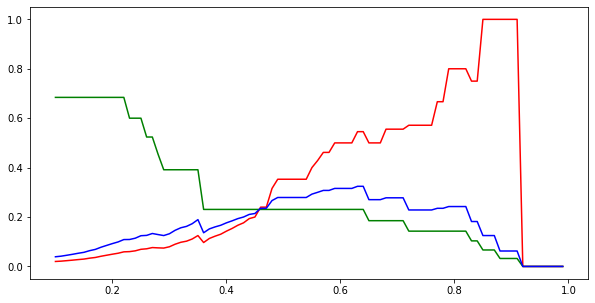

0.6299999999999997
             name  precision    recall        f1
0  cmt-confOf.rdf   0.545455  0.230769  0.324324
precision    0.545455
recall       0.230769
f1           0.324324
dtype: float64


oracle th ---------------------
             name  precision    recall        f1    th
0  cmt-confOf.rdf   0.545455  0.230769  0.324324  0.63
precision    0.545455
recall       0.230769
f1           0.324324
dtype: float64
glove


  0%|          | 0/1 [00:00<?, ?it/s]

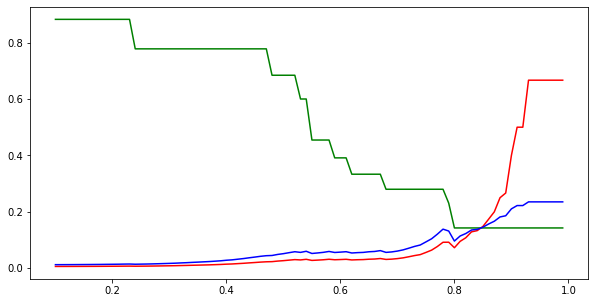

0.9299999999999996
             name  precision    recall        f1
0  cmt-confOf.rdf   0.666667  0.142857  0.235294
precision    0.666667
recall       0.142857
f1           0.235294
dtype: float64


oracle th ---------------------
             name  precision    recall        f1    th
0  cmt-confOf.rdf   0.666667  0.142857  0.235294  0.93
precision    0.666667
recall       0.142857
f1           0.235294
dtype: float64


In [37]:
print('=' * 100)
print('kgome')
print('=' * 100)

runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=Matcher())
result = runner.run(refs=[
    '/moredata/gsantos/canard/reference/cmt-confOf.rdf'
], parallel=False)

eval_result(result, rang)

print('=' * 100)
print('glove')
print('=' * 100)

runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=GloveMatcher())
result = runner.run(refs=[
    '/moredata/gsantos/canard/reference/cmt-confOf.rdf'
], parallel=False)

eval_result(result, rang)
#
# print('=' * 100)
# print('eq match')
# print('=' * 100)
#
# runner = Runner('/moredata/gsantos/canard/conference', '/moredata/gsantos/canard/reference', matcher=EqMatcher())
#
# result = runner.run(refs=[
#     '/moredata/gsantos/canard/reference/ekaw-iasted.rdf',
#     '/moredata/gsantos/canard/reference/ekaw-sigkdd.rdf',
#     '/moredata/gsantos/canard/reference/iasted-sigkdd.rdf'
# ], parallel=False)
#
# eval_result(result, [1])